In [72]:
from __future__ import print_function
import pickle
from matplotlib import pyplot
import numpy as np
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
from sklearn.metrics import roc_curve, auc, roc_auc_score
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from google.colab import drive
drive.mount('/content/gdrive')
PATHDOM = './gdrive/My Drive/Colab Notebooks/siamesedom.pt'
PATHPROC = './gdrive/My Drive/Colab Notebooks/siameseproc.pt'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!sudo apt-get --purge --reinstall install ttf-mscorefonts-installer


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cabextract debconf libmspack0 python3-chardet python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-pkg-resources python3-six
  python3-update-manager ubuntu-release-upgrader-core update-manager-core
  update-notifier-common xfonts-encodings xfonts-utils
Suggested packages:
  debconf-doc debconf-utils whiptail | dialog libterm-readline-gnu-perl
  libgtk3-perl libnet-ldap-perl libqtgui4-perl libqtcore4-perl
  python3-setuptools python3-launchpadlib
Recommended packages:
  debconf-i18n
The following NEW packages will be installed:
  cabextract libmspack0 python3-chardet python3-debconf python3-debian
  python3-distro-info python3-distupgrade python3-pkg-resources python3-six


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [0]:
dataset_type = 'process'
#dataset_type = 'domain'

OUTPUT_DIR = 'output'

if dataset_type == 'domain':
    OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'domain_results.pkl')
    INPUT_FILE = os.path.join('./gdrive/My Drive/Colab Notebooks/data', 'domains_spoof.pkl')
    IMAGE_FILE = os.path.join(OUTPUT_DIR, 'domains_roc_curve.png')
    OUTPUT_NAME = 'Domain Spoofing'
elif dataset_type == 'process':
    OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'process_results.pkl')
    INPUT_FILE = os.path.join('./gdrive/My Drive/Colab Notebooks/data', 'process_spoof.pkl')
    IMAGE_FILE = os.path.join(OUTPUT_DIR, 'process_roc_curve.png')
    OUTPUT_NAME = 'Process Spoofing'
else:
    raise Exception('Unknown dataset type: %s' % (dataset_type,))

In [0]:
def generate_imgs(strings, font_location, font_size, image_size, text_location):
    font = ImageFont.truetype(font_location, font_size)

    str_imgs = []

    for st in strings:
        # Create a single channel image of floats
        img1 = Image.new('F', image_size)
        dimg = ImageDraw.Draw(img1)
        dimg.text(text_location, st.lower(), font=font)
        
        img1 = np.expand_dims(img1, axis=0)

        str_imgs.append(img1)

    return np.array(str_imgs, dtype=np.float32)

In [0]:
font_location = "Arial.ttf"
font_size = 10
image_size = (150, 12)
text_location = (0, 0)

with open(INPUT_FILE, 'rb') as f:
    data = pickle.load(f)
        
data['train'] = random.sample(data['train'], 20000)
data['validate'] = random.sample(data['validate'], 1000)
data['test'] = random.sample(data['test'], 1000)

In [9]:
data['train'][20:30]

[('SOLUTILS.DLL', 'solutilŝ.dll', 1.0),
 ('CSSsrv.exe', 'ćsssrv.exe', 1.0),
 ('REGTOOL.DLL', 'regtooly.dll', 1.0),
 ('SAGECMD.EXE', 'saġeecmď.exe', 1.0),
 ('SPLINTL.DLL', 'sssintl.dll', 0.0),
 ('IE7-WindowsServer2003-KB3003057-x64-ITA.exe',
  'ie7-windowsserver2003-kb3003057-x64-fra.exe',
  0.0),
 ('nxzipvs10xu.dll', 'nxzipv-s10xuv.dll', 1.0),
 ('asuschp0.dll', 'asuschn0.dll', 0.0),
 ('QTEST32.EXE', 'sptest32.exe', 0.0),
 ('MMOPN32.exe', 'mm-opn36f.exe', 1.0)]

In [0]:
X1_train = generate_imgs([x[0] for x in data['train']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) ) 
X2_train = generate_imgs([x[1] for x in data['train']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_train = [x[2] for x in data['train']]

X1_valid = generate_imgs([x[0] for x in data['validate']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
X2_valid = generate_imgs([x[1] for x in data['validate']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_valid = [x[2] for x in data['validate']]

X1_test = generate_imgs([x[0] for x in data['test']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
X2_test = generate_imgs([x[1] for x in data['test']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_test = [x[2] for x in data['test']]

1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0


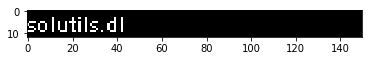

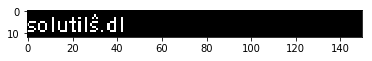

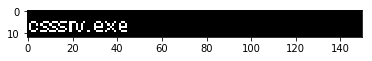

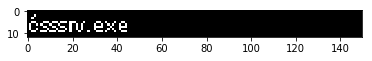

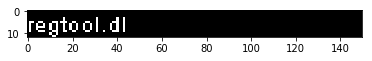

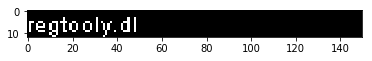

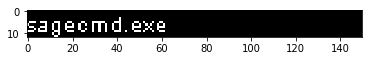

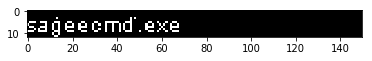

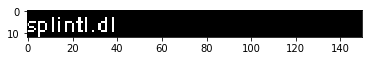

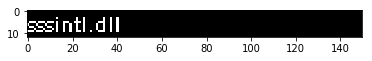

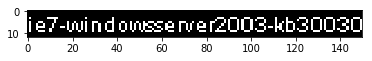

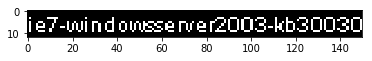

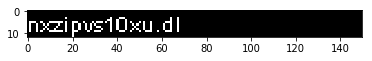

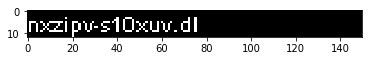

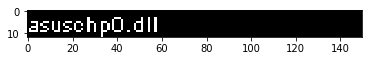

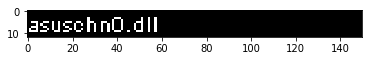

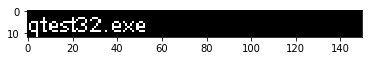

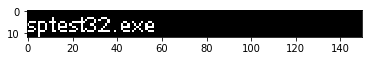

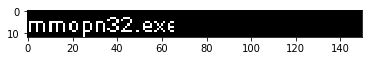

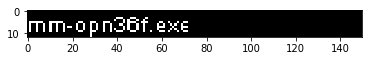

In [10]:
for ii in range(20, 30):
    iii = X1_train[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
    iii = X2_train[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
    print(y_train[ii])

In [11]:
def permute_shapes(collection):
    return collection.permute(0, 3, 1, 2)

def tensorify(collection):
    return torch.from_numpy(collection)

def arrange_dataset(X1, X2, y, batch_size=8, shuffle=True):
    X1_new = X1.unsqueeze(1)
    X2_new = X2.unsqueeze(1)
    y_new = torch.FloatTensor(y)
    
    dataset_large = torch.cat((X1_new, X2_new), 1)
    print(dataset_large.shape)
    print(y_new.shape)

    from torch.utils.data import DataLoader
    from torch.utils.data import TensorDataset
    dataset_large = dataset_large.to(device)
    y_new = y_new.to(device)
    large_dataset = TensorDataset(dataset_large, y_new)
    large_data_loader = DataLoader(large_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return large_data_loader

X1_train = permute_shapes(tensorify(X1_train))
X2_train = permute_shapes(tensorify(X2_train))
X1_valid = permute_shapes(tensorify(X1_valid))
X2_valid = permute_shapes(tensorify(X2_valid))
X1_test = permute_shapes(tensorify(X1_test))
X2_test = permute_shapes(tensorify(X2_test))

train_loader = arrange_dataset(X1_train, X2_train, y_train)
valid_loader = arrange_dataset(X1_valid, X2_valid, y_valid)
test_loader = arrange_dataset(X1_test, X2_test, y_test)

torch.Size([20000, 2, 1, 12, 150])
torch.Size([20000])
torch.Size([1000, 2, 1, 12, 150])
torch.Size([1000])
torch.Size([1000, 2, 1, 12, 150])
torch.Size([1000])


In [0]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin=margin

    def forward(self, output1, output2, label):
        output1 = output1.type(torch.FloatTensor)
        output2 = output2.type(torch.FloatTensor)
        label = label.type(torch.FloatTensor)

        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(label * torch.pow(euclidean_distance, 2) +
                                      (1 - label)   * torch.pow(torch.clamp(self.margin-euclidean_distance, min=0.0), 2))

        return loss_contrastive

class Siamese_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.fc = nn.Linear(64 * 35, 32)

    def forward_once(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 35)
        return self.fc(x)
    
    def forward(self, input1, input2):
        return self.forward_once(torch.cat((input1, input2), 0))

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.340239
Train Epoch: 1 [4000/20000 (20%)]	Loss: 0.138480
Train Epoch: 1 [8000/20000 (40%)]	Loss: 0.233297
Train Epoch: 1 [12000/20000 (60%)]	Loss: 0.163031
Train Epoch: 1 [16000/20000 (80%)]	Loss: 0.258855


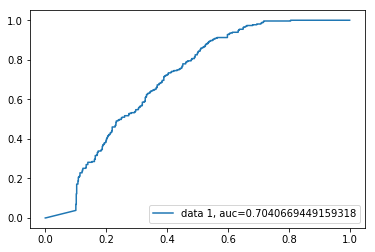


Test set: Average loss: 0.2699

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.037578
Train Epoch: 2 [4000/20000 (20%)]	Loss: 0.133652
Train Epoch: 2 [8000/20000 (40%)]	Loss: 0.352635
Train Epoch: 2 [12000/20000 (60%)]	Loss: 0.124158
Train Epoch: 2 [16000/20000 (80%)]	Loss: 0.320842


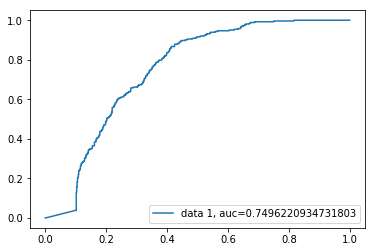


Test set: Average loss: 0.2680

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.313443
Train Epoch: 3 [4000/20000 (20%)]	Loss: 0.160707
Train Epoch: 3 [8000/20000 (40%)]	Loss: 0.284376
Train Epoch: 3 [12000/20000 (60%)]	Loss: 0.171031
Train Epoch: 3 [16000/20000 (80%)]	Loss: 0.208383


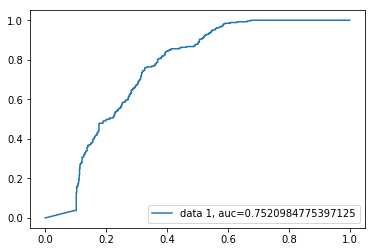


Test set: Average loss: 0.2592

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.043688
Train Epoch: 4 [4000/20000 (20%)]	Loss: 0.075123
Train Epoch: 4 [8000/20000 (40%)]	Loss: 0.152917
Train Epoch: 4 [12000/20000 (60%)]	Loss: 0.176502
Train Epoch: 4 [16000/20000 (80%)]	Loss: 0.261619


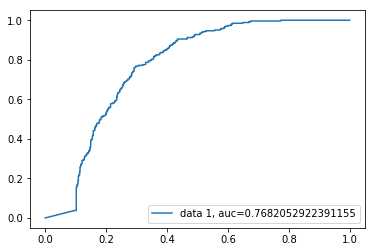


Test set: Average loss: 0.2358

Train Epoch: 5 [0/20000 (0%)]	Loss: 0.208988
Train Epoch: 5 [4000/20000 (20%)]	Loss: 0.150994
Train Epoch: 5 [8000/20000 (40%)]	Loss: 0.356262
Train Epoch: 5 [12000/20000 (60%)]	Loss: 0.119832
Train Epoch: 5 [16000/20000 (80%)]	Loss: 0.022164


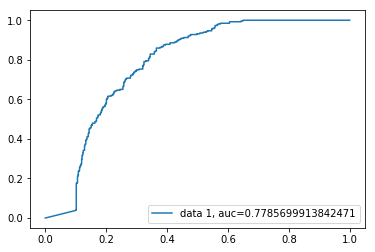


Test set: Average loss: 0.2357

Train Epoch: 6 [0/20000 (0%)]	Loss: 0.243347
Train Epoch: 6 [4000/20000 (20%)]	Loss: 0.094718
Train Epoch: 6 [8000/20000 (40%)]	Loss: 0.372307
Train Epoch: 6 [12000/20000 (60%)]	Loss: 0.042407
Train Epoch: 6 [16000/20000 (80%)]	Loss: 0.219789


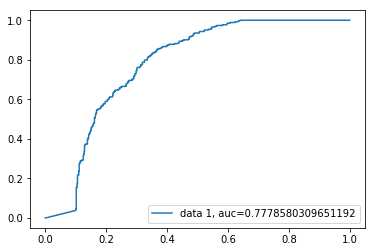


Test set: Average loss: 0.2320

Train Epoch: 7 [0/20000 (0%)]	Loss: 0.179914
Train Epoch: 7 [4000/20000 (20%)]	Loss: 0.179038
Train Epoch: 7 [8000/20000 (40%)]	Loss: 0.051488
Train Epoch: 7 [12000/20000 (60%)]	Loss: 0.074862
Train Epoch: 7 [16000/20000 (80%)]	Loss: 0.318650


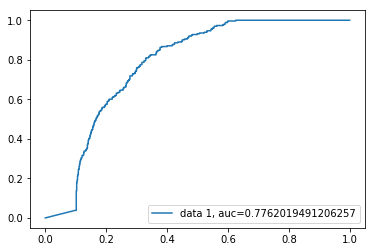


Test set: Average loss: 0.2350

Train Epoch: 8 [0/20000 (0%)]	Loss: 0.245234
Train Epoch: 8 [4000/20000 (20%)]	Loss: 0.094665
Train Epoch: 8 [8000/20000 (40%)]	Loss: 0.164748
Train Epoch: 8 [12000/20000 (60%)]	Loss: 0.238953
Train Epoch: 8 [16000/20000 (80%)]	Loss: 0.089033


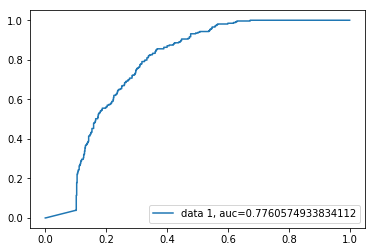


Test set: Average loss: 0.2323

Train Epoch: 9 [0/20000 (0%)]	Loss: 0.201017
Train Epoch: 9 [4000/20000 (20%)]	Loss: 0.256859
Train Epoch: 9 [8000/20000 (40%)]	Loss: 0.070546
Train Epoch: 9 [12000/20000 (60%)]	Loss: 0.079773
Train Epoch: 9 [16000/20000 (80%)]	Loss: 0.220260


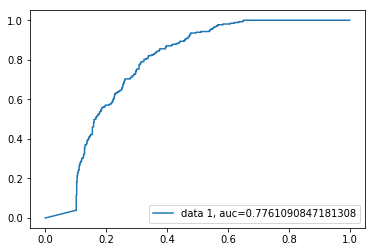


Test set: Average loss: 0.2294

Train Epoch: 10 [0/20000 (0%)]	Loss: 0.107992
Train Epoch: 10 [4000/20000 (20%)]	Loss: 0.216148
Train Epoch: 10 [8000/20000 (40%)]	Loss: 0.066789
Train Epoch: 10 [12000/20000 (60%)]	Loss: 0.036433
Train Epoch: 10 [16000/20000 (80%)]	Loss: 0.319185


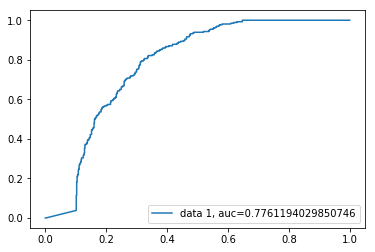


Test set: Average loss: 0.2294

Train Epoch: 11 [0/20000 (0%)]	Loss: 0.275456
Train Epoch: 11 [4000/20000 (20%)]	Loss: 0.173286
Train Epoch: 11 [8000/20000 (40%)]	Loss: 0.173496
Train Epoch: 11 [12000/20000 (60%)]	Loss: 0.079690
Train Epoch: 11 [16000/20000 (80%)]	Loss: 0.030763


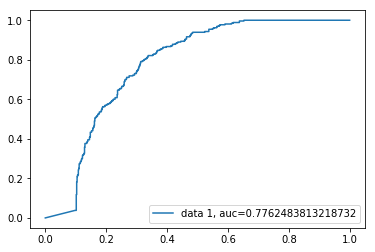


Test set: Average loss: 0.2291

Train Epoch: 12 [0/20000 (0%)]	Loss: 0.181822
Train Epoch: 12 [4000/20000 (20%)]	Loss: 0.116681
Train Epoch: 12 [8000/20000 (40%)]	Loss: 0.118265
Train Epoch: 12 [12000/20000 (60%)]	Loss: 0.119914
Train Epoch: 12 [16000/20000 (80%)]	Loss: 0.168875


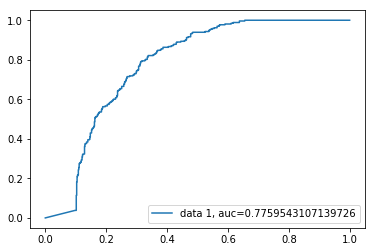


Test set: Average loss: 0.2289

Train Epoch: 13 [0/20000 (0%)]	Loss: 0.086434
Train Epoch: 13 [4000/20000 (20%)]	Loss: 0.095963
Train Epoch: 13 [8000/20000 (40%)]	Loss: 0.208907
Train Epoch: 13 [12000/20000 (60%)]	Loss: 0.149064
Train Epoch: 13 [16000/20000 (80%)]	Loss: 0.025323


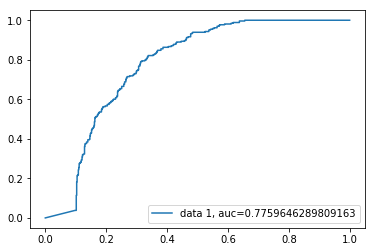


Test set: Average loss: 0.2288

Train Epoch: 14 [0/20000 (0%)]	Loss: 0.182368
Train Epoch: 14 [4000/20000 (20%)]	Loss: 0.179147
Train Epoch: 14 [8000/20000 (40%)]	Loss: 0.276584
Train Epoch: 14 [12000/20000 (60%)]	Loss: 0.159221
Train Epoch: 14 [16000/20000 (80%)]	Loss: 0.275297


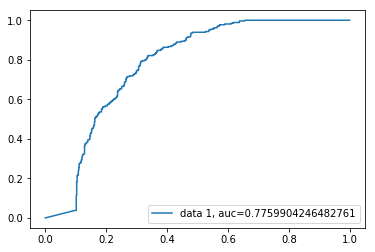


Test set: Average loss: 0.2288

Train Epoch: 15 [0/20000 (0%)]	Loss: 0.086458
Train Epoch: 15 [4000/20000 (20%)]	Loss: 0.033352
Train Epoch: 15 [8000/20000 (40%)]	Loss: 0.056745
Train Epoch: 15 [12000/20000 (60%)]	Loss: 0.182948
Train Epoch: 15 [16000/20000 (80%)]	Loss: 0.142003


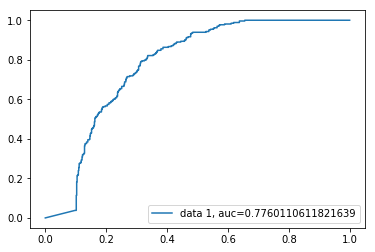


Test set: Average loss: 0.2287



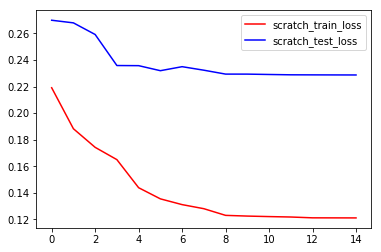

In [40]:
siamese = Siamese_CNN().to(device)
optimizer_siamese = optim.Adam(siamese.parameters(), lr=0.001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_siamese, step_size=4, gamma=0.1)

criterion = ContrastiveLoss().to(device)

def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()
    
    
def train(model, device, train_loader, optimizer, epoch, batch_size=8):
    log_interval = int(4000 / batch_size)
    
    model.train()
    train_loss = 0
    num_iter = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        data_permuted = data.permute(1, 0, 2, 3, 4)
        data1 = data_permuted[0]
        data2 = data_permuted[1]
        
        output = model(data1, data2)
        output1 = output[:batch_size]
        output2 = output[batch_size:]
        
        # compute average loss for the current batch
        loss = criterion(output1, output2, target)
        train_loss += loss
        # backpropagate the gradients
        loss.backward()
        optimizer.step()
        num_iter += 1
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


    train_loss /= num_iter
    return train_loss.item()
            
def validate(model, device, validation_loader, optimizer, epoch, batch_size=8):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            data_permuted = data.permute(1, 0, 2, 3, 4)
            data1 = data_permuted[0]
            data2 = data_permuted[1]

            output = model(data1, data2)
            output1 = output[:batch_size]
            output2 = output[batch_size:]
            
            test_loss +=  criterion(output1, output2, target)
            num_iter += 1
    
    test_loss /= num_iter
    
    validation_batch = validation_loader.dataset.tensors[0].permute(1, 0, 2, 3, 4)
    validation_labels = validation_loader.dataset.tensors[1].cpu().detach().numpy()
    output = model(validation_batch[0], validation_batch[1])
    outs1 = output[:1000]
    outs2 = output[1000:]
    dists = F.pairwise_distance(outs1, outs2)
    classified = dists.cpu().detach().numpy()
    fpr, tpr, _ = roc_curve(validation_labels,  -classified)
    auc = roc_auc_score(validation_labels, -classified)
    pyplot.plot(fpr,tpr,label="data 1, auc="+str(auc))
    pyplot.legend(loc=4)
    pyplot.show()

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

  
losses_train_pre = []
losses_test_pre = []

for epoch in range(1, 15 + 1):    
    losses_train_pre.append(train(siamese, None, train_loader, optimizer_siamese, epoch))
    losses_test_pre.append(validate(siamese, None, valid_loader, optimizer_siamese, epoch))
    lrscheduler.step()
    
plot_loss(losses_train_pre,'scratch_train_loss','red')
plot_loss(losses_test_pre,'scratch_test_loss')

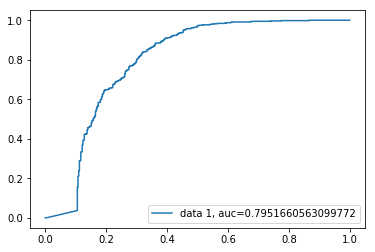

In [49]:
# def checker(loader):
#     for i in range(10):
#         input1 = loader.dataset.tensors[0][i][0].to(device)
#         input2 = loader.dataset.tensors[0][i][1].to(device)
#         label = loader.dataset.tensors[1][i]
#         o1, o2 = siamese(input1.unsqueeze(0), input2.unsqueeze(0))
#         o1, o2 = o1.to(device), o2.to(device)
        
#         iii = input1.reshape((12, 150)).to(device)
#         pyplot.figure()
#         pyplot.imshow(iii, cmap="gray")

#         iii = input2.reshape((12, 150)).to(device)
#         pyplot.figure()
#         pyplot.xlabel("{:.0f}".format(label.item()) + " vs " + "{:.6f}".format(F.pairwise_distance(o1, o2).item()))
#         pyplot.imshow(iii, cmap="gray")
        
# checker(valid_loader)

test_batch = test_loader.dataset.tensors[0].permute(1, 0, 2, 3, 4)
test_labels = test_loader.dataset.tensors[1].cpu().detach().numpy()
output = siamese(test_batch[0], test_batch[1])
outs1 = output[:1000]
outs2 = output[1000:]
dists = F.pairwise_distance(outs1, outs2)
classified = dists.cpu().detach().numpy()
fpr, tpr, _ = roc_curve(test_labels,  -classified)
auc = roc_auc_score(test_labels, -classified)
pyplot.plot(fpr,tpr,label="data 1, auc="+str(auc))
pyplot.legend(loc=4)
pyplot.show()


In [76]:
# torch.save(siamese, PATHPROC)
# loaded = torch.load(PATHPROC)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Siamese_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


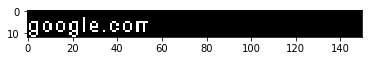

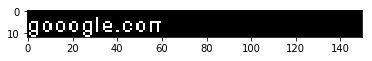

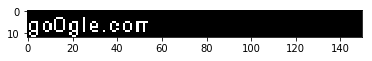

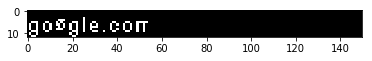

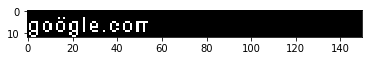

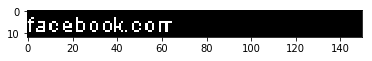

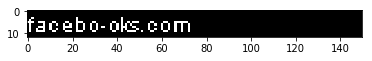

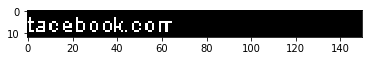

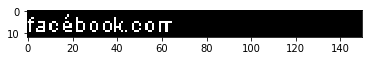

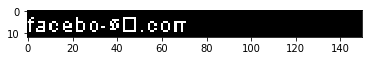

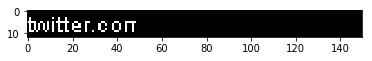

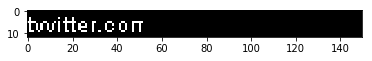

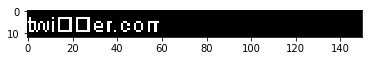

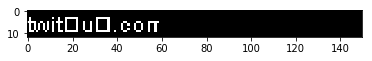

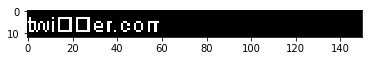

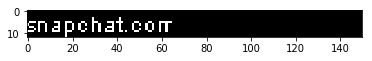

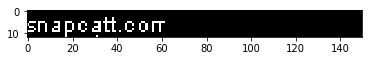

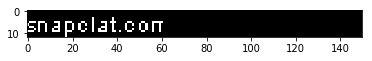

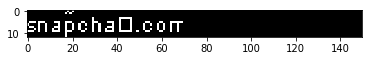

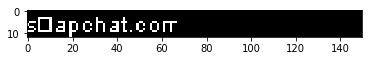

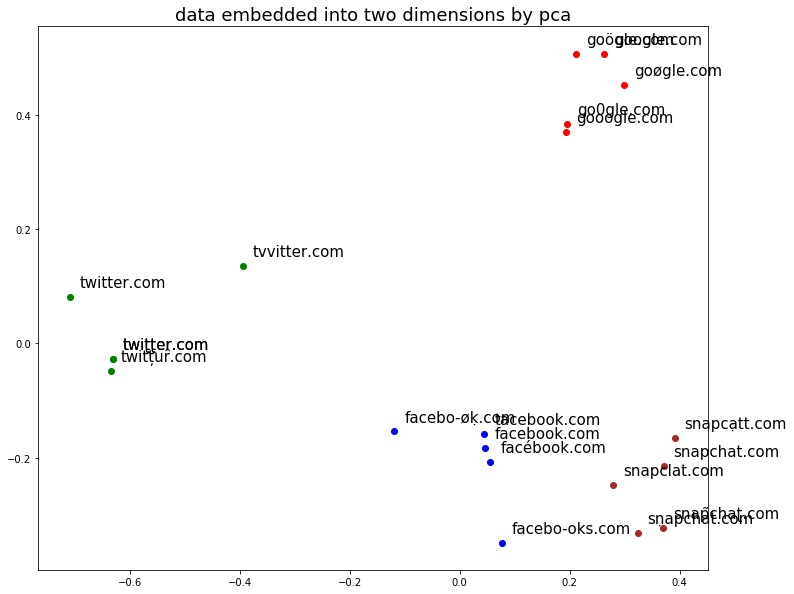

In [77]:
pca_test = ['google.com', 'gooogle.com', 'go0gle.com', 'goøgle.com', 'goögle.com',
            'facebook.com', 'facebo-oks.com', 'tacebook.com', 'facébook.com', 'facebo-øḳ.com',
            'twitter.com', 'tvvitter.com', 'twițțer.com', 'twitțuȓ.com', 'twiʈʈer.com',
            'snapchat.com', 'snapcạtt.com', 'snapclat.com', 'snap̃chaʈ.com', 'sṇapchat.com']
pca_images_test = torch.tensor(generate_imgs(pca_test, font_location, font_size, image_size, text_location))
for ii in range(len(pca_test)):
    iii = pca_images_test[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
pca_images_test = pca_images_test.to(device)

outputs = loaded(pca_images_test[:10], pca_images_test[10:])
labels = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
colors = ['red', 'blue', 'green', 'brown']

from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=2, batch_size=20)
pca_embedded = ipca.fit_transform(outputs.cpu().detach().numpy())
fig, ax = pyplot.subplots(figsize=(12, 10))


for i,type in enumerate(labels):
    x = pca_embedded[i][0]
    y = pca_embedded[i][1]
    pyplot.scatter(x, y, marker='o', color=colors[labels[i]])
    pyplot.annotate(pca_test[i], (x, y), fontsize=15, xytext=(10, 10), textcoords='offset points')
pyplot.title("data embedded into two dimensions by pca", fontsize=18)
pyplot.show()

In [71]:
data['train']

[('ymdp.dll', 'mdp.dll', 1.0),
 ('wshru.dll', 'wsjru.dll', 1.0),
 ('webrstr-CAT.dll', 'uëbrštr-cat.dll', 1.0),
 ('IRPSetup.exe', 'iprsetut.exe', 1.0),
 ('mphook.dll', 'mphooki.dll', 1.0),
 ('CmAGS.exe', 'cmaggx.exe', 1.0),
 ('chrome_frame_helper.exe', 'chrome_frame_helper.exe', 1.0),
 ('Microsoft.SpeechServer.Core.cn.resources.dll',
  'microsoft.speechserver.core.es.resources.dll',
  0.0),
 ('chsinst.dll', 'cciinst.dll', 0.0),
 ('vesetup.exe', 'bdsetup.exe', 0.0),
 ('__setup.exe', 'sfsetup.exe', 0.0),
 ('SecMA.dll', 'secmai.dll', 1.0),
 ('tsreg.exe', 'tsmreg.exe', 0.0),
 ('WINDOWSXP-KB2659262-X86-FIN.EXE', 'wiñdowsxp-ķb2651262-x86-fin.exe', 1.0),
 ('Q251381_W2K_SP1_X86_NL.EXE', 'q251381_w2k_sp1_x86_nl.exe', 1.0),
 ('cp000013.exe', 'cp000029.exe', 0.0),
 ('PPTPFIXI.EXE', 'pþʈƥfixi.exe', 1.0),
 ('WINDOWSXP-KB2727528-X86-CHT.EXE', 'windowsxp-kb2718523-x86-cht.exe', 0.0),
 ('FRIntegration.x64.15.dll', 'friñteġraťion.x64.15.dll', 1.0),
 ('_dtrans.dll', 'pxdtrans.dll', 0.0),
 ('SOLUTILS.DLL'